<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 50px">Le Machine Learning par la pratique</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>




In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import datetime
import sys
%matplotlib inline

In [2]:
ROOT_DIR = os.getcwd()
DATA ='data_challenge'
DATA_DIR = os.path.join(ROOT_DIR, DATA)
TRAIN="train"
TEST="test"
SOURCE="source"
TARGET="prix"

In [3]:
def displayUniqueCount(series):
    data = np.unique(series, return_counts=True)
    df = pd.DataFrame(
        data = {'Valeur':data[0], 'Nombre':data[1]},
        columns = ['Valeur', 'Nombre'])
    df.sort_values(by ="Nombre", ascending=False, inplace=True)
    return df

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 240px">Les données</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>



## Import des données


In [4]:
train = pd.read_csv(os.path.join(DATA_DIR, 'boites_medicaments_train.csv'),
                    encoding='utf-8',
                    sep=';')

test = pd.read_csv(os.path.join(DATA_DIR, 'boites_medicaments_test.csv'),
                   encoding='utf-8', 
                   sep=';')

train[SOURCE] = TRAIN
test[SOURCE] = TEST
BIG = pd.concat([train, test], axis=0)

print "TRAIN", train.shape
print "TEST ", test.shape
print "BIG ", BIG.shape

TRAIN (8564, 42)
TEST  (3671, 42)
BIG  (12235, 43)


## Affichage des données


In [5]:
pd.set_option("display.max_columns", 43) # permet de voir toutes les colonnes
BIG.head(10)

,agrement col,date amm annee,date declar annee,etat commerc,forme pharma,id,libelle,libelle_ampoule,libelle_capsule,libelle_comprime,libelle_film,libelle_flacon,libelle_gelule,libelle_pilulier,libelle_plaquette,libelle_poche,libelle_sachet,libelle_seringue,libelle_stylo,libelle_tube,nb_ampoule,nb_capsule,nb_comprime,nb_film,nb_flacon,nb_gelule,nb_ml,nb_pilulier,nb_plaquette,nb_poche,nb_sachet,nb_seringue,nb_stylo,nb_tube,prix,source,statut,statut admin,substances,titulaires,tx rembours,type proc,voies admin
0,oui,2014,2014,Déclaration de commercialisation,comprimé pelliculé,NaN,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,28,0,0,0,0.0,0,3,0,0,0,0,0,2.83,train,Présentation active,Autorisation active,DÉSOGESTREL,MAJORELLE LUXEMBOURG SOPARFI (LUXEMBOURG),65%,Procédure décentralisée,orale
1,oui,2009,2013,Déclaration de commercialisation,comprimé à croquer,NaN,plaquette(s) thermoformée(s) aluminium de 28 c...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,28,0,0,0,0.0,0,0,0,0,0,0,0,14.30,train,Présentation active,Autorisation active,"MONTÉLUKAST ACIDE, MONTÉLUKAST SODIQUE",TEVA SANTE,65%,Procédure de reconnaissance mutuelle,orale
2,oui,1996,2000,Déclaration de commercialisation,gélule à libération prolongée,NaN,plaquette(s) thermoformée(s) PVC-aluminium de ...,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,30,0.0,0,0,0,0,0,0,0,5.66,train,Présentation active,Autorisation active,CHLORHYDRATE DE DILTIAZEM,MYLAN SAS,65%,Procédure nationale,orale
3,oui,2004,2005,Déclaration de commercialisation,granulés à libération prolongée,NaN,30 sachet(s)-dose(s) papier aluminium complexe...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,30,0,0,0,24.27,train,Présentation active,Autorisation active,"ACIDE VALPROÏQUE, VALPROATE DE SODIUM",SANOFI AVENTIS FRANCE,65%,Procédure nationale,orale
4,non,2010,2015,Déclaration d'arrêt de commercialisation,comprimé pelliculé,NaN,plaquette(s) thermoformée(s) PVC-Aluminium de ...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0.0,0,0,0,0,0,0,0,59.94,train,Présentation active,Autorisation active,LÉTROZOLE,TEVA SANTE,100%,Procédure nationale,orale
5,oui,2000,2001,Déclaration de commercialisation,comprimé,NaN,plaquette(s) thermoformée(s) PVC-aluminium de ...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0.0,0,0,0,0,0,0,0,27.17,train,Présentation active,Autorisation active,FLUTAMIDE,EG LABO - LABORATOIRES EUROGENERICS,100%,Procédure nationale,orale
6,oui,2001,2015,Déclaration de commercialisation,capsule molle,NaN,flacon(s) polyéthylène haute densité (PEHD) de...,0,1,0,0,1,0,0,0,0,0,0,0,0,0,100,0,0,0,0,0.0,0,0,0,0,0,0,0,877.83,train,Présentation active,Autorisation active,BEXAROTÈNE,EISAI (ROYAUME-UNI),100%,Procédure centralisée,orale
7,oui,2006,2006,Déclaration de commercialisation,comprimé,NaN,plaquette(s) thermoformée(s) PVC polyéthylène ...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,30,0,0,0,0.0,0,0,0,0,0,0,0,6.58,train,Présentation active,Autorisation active,GLIMÉPIRIDE,SANDOZ,65%,Procédure de reconnaissance mutuelle,orale
8,oui,2002,2013,Déclaration d'arrêt de commercialisation,comprimé sécable,NaN,plaquette(s) thermoformée(s) PVC-Aluminium de ...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,90,0,0,0,0.0,0,0,0,0,0,0,0,18.63,train,Présentation active,Autorisation active,MALÉATE D'ÉNALAPRIL,ARROW GENERIQUES,65%,Procédure nationale,orale
9,non,2012,2015,Déclaration de commercialisation,comprimé pelliculé,NaN,plaquette(s) polyamide aluminium PVC de 10 com...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0.0,0,0,0,0,0,0,0,6.13,train,Présentation active,Autorisation active,"CEFPODOXIME PROXÉTIL, CEFPODOXIME",ARROW GENERIQUES,65%,Procédure nationale,orale


<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 150px">Les données numériques</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>

## Les libellés : description du contenu de la boite de médicaments


In [6]:
print train['libelle'][0]

3 plaquette(s) thermoformée(s) PVC-Aluminium de 28 comprimé(s)


Extraction des libéllés

In [7]:
train[['libelle','libelle_plaquette','libelle_ampoule','libelle_flacon','libelle_tube',
       'libelle_stylo','libelle_seringue','libelle_pilulier','libelle_sachet',
       'libelle_comprime','libelle_gelule','libelle_film','libelle_poche','libelle_capsule']].head(1)

,libelle,libelle_plaquette,libelle_ampoule,libelle_flacon,libelle_tube,libelle_stylo,libelle_seringue,libelle_pilulier,libelle_sachet,libelle_comprime,libelle_gelule,libelle_film,libelle_poche,libelle_capsule
0,3 plaquette(s) thermoformée(s) PVC-Aluminium d...,1,0,0,0,0,0,0,0,1,0,0,0,0


Extraction du nombre

In [9]:
train[['nb_plaquette','nb_ampoule','nb_flacon','nb_tube','nb_stylo','nb_seringue','nb_pilulier','nb_sachet',
       'nb_comprime','nb_gelule','nb_film','nb_poche','nb_capsule','nb_ml']].head(1)

,nb_plaquette,nb_ampoule,nb_flacon,nb_tube,nb_stylo,nb_seringue,nb_pilulier,nb_sachet,nb_comprime,nb_gelule,nb_film,nb_poche,nb_capsule,nb_ml
0,3,0,0,0,0,0,0,0,28,0,0,0,0,0.0


## Année de la déclaration de commercialisation de la boîte de médicament

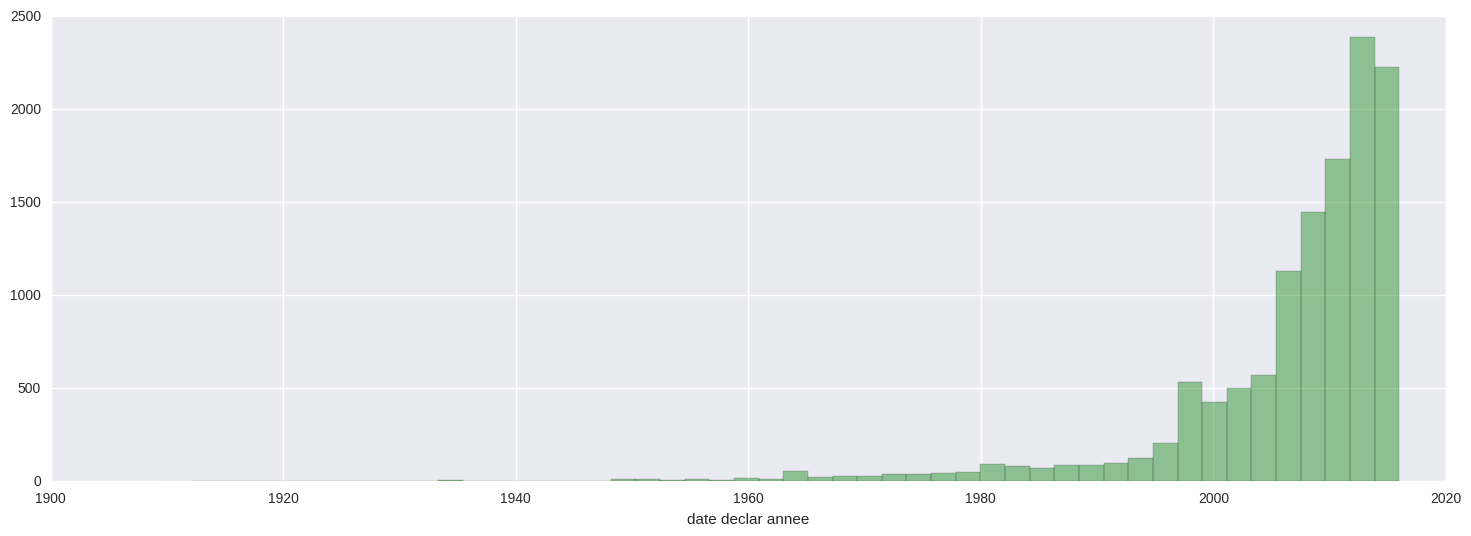

In [10]:
plt.figure(figsize=(18, 6))
sns.distplot(BIG['date declar annee'], color='green', kde=False) #kde = Kernel Density

## Année d’Autorisation de Mise sur le Marché du médicament 

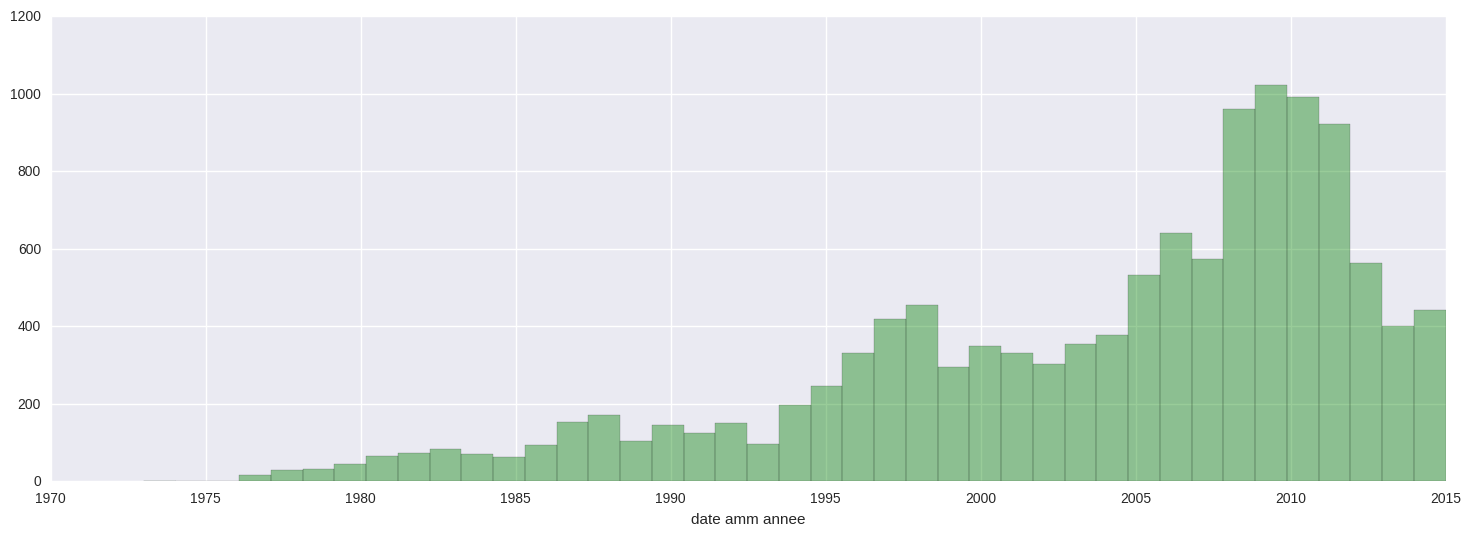

In [11]:
plt.figure(figsize=(18, 6))
sns.distplot(BIG['date amm annee'], color='green', kde=False)

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 130px">Les données catégorielles</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>




## Statut administratif de la boite de médicament

In [12]:
displayUniqueCount(BIG['statut admin'])

,Valeur,Nombre
1,Autorisation active,11673
0,Autorisation abrogée,440
2,Autorisation archivée,110
3,Autorisation retirée,11
4,Autorisation suspendue,1


## Etat de commercialisation de la boîte de médicament tel que déclaré par le titulaire de l'AMM

In [13]:
pd.set_option("display.max_colwidth", 100)
displayUniqueCount(BIG['etat commerc'])

,Valeur,Nombre
2,Déclaration de commercialisation,10395
1,Déclaration d'arrêt de commercialisation,1770
0,Arrêt de commercialisation (le médicament n'a plus d'autorisation),69
3,Déclaration de suspension de commercialisation,1


## Agrément aux collectivités

In [ ]:
displayUniqueCount(BIG['agrement col'])

## Statut administratif de l’autorisation de mise sur le marché (AMM)

In [ ]:
displayUniqueCount(BIG['statut admin'])

## Type de procédure d'autorisation de mise sur le marché (AMM) (Nationale, décentralisée, reconnaissance mutuelle, ...)

In [ ]:
displayUniqueCount(BIG['type proc'])

## Taux de remboursement

In [ ]:
displayUniqueCount(BIG['tx rembours'])

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 170px">Les données textuelles</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>

## Forme pharmaceutique

In [ ]:
displayUniqueCount(BIG['forme pharma']).head(10)

## Laboratoire titulaire du médicament.
S'il y a plusieurs titulaires, ils sont séparés par des « , »

In [15]:
displayUniqueCount(BIG['titulaires']).head(15)

,Valeur,Nombre
333,TEVA SANTE,1086
296,SANOFI AVENTIS FRANCE,831
235,MYLAN SAS,818
56,BIOGARAN,717
34,ARROW GENERIQUES,655
293,SANDOZ,630
98,EG LABO - LABORATOIRES EUROGENERICS,608
280,RANBAXY PHARMACIE GENERIQUES,383
352,ZYDUS FRANCE,375
85,CRISTERS,304


## Substances présentes dans le médicament.
S'il y en a plusieurs, elles sont séparées par des « , » 

In [14]:
displayUniqueCount(BIG['substances'])[15:20]

,Valeur,Nombre
962,GLICLAZIDE,82
609,CLARITHROMYCINE,73
1023,"HYDROCHLOROTHIAZIDE, VALSARTAN",72
549,CHLORHYDRATE DE TRAMADOL,72
1747,SPIRONOLACTONE,71


## Voies d'administration
(avec un séparateur « , » entre chaque valeur quand il y en a plusieurs : orale, ophtalmique, intramusculaire, ...)

In [16]:
displayUniqueCount(BIG['voies admin']).head(8)

,Valeur,Nombre
66,orale,9926
58,intraveineuse,325
3,cutanée,308
65,ophtalmique,242
70,sous-cutanée,239
24,inhalée,136
60,"intraveineuse,sous-cutanée",129
73,transdermique,125


<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 15px">Le Data Cleaning et le Feature Engineering</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>

## Exemple DUMMY & ENCODE

In [6]:
BASKET_DF = pd.DataFrame(
    data = {'JOUEUR':["Tony PARKER","Michael JORDAN","Kobe BRYANT", "Michael JORDAN"],
            'NUMERO':["9","23","8","45"]},
    columns=['JOUEUR', 'NUMERO'])

BASKET_DF

BASKET_DF

,JOUEUR,NUMERO
0,Tony PARKER,9
1,Michael JORDAN,23
2,Kobe BRYANT,8
3,Michael JORDAN,45


## Encodage des features catégorielles

Les algorithmes de machine learning s'attendent à avoir en entrée des nombres, et non pas des chaînes de caractères. C'est pourquoi nous transformons les features catégorielles en nombres, à l'aide de LabelEncoder()

In [8]:
#Feature to encode
encodeToCat ="JOUEUR"

print "ENCODAGE de la variable " + encodeToCat

le = LabelEncoder()

le.fit(BASKET_DF[encodeToCat])

BASKET_DF.loc[:,encodeToCat+" ENCODED"] = le.transform(BASKET_DF[encodeToCat])

BASKET_DF

ENCODAGE de la variable JOUEUR


,JOUEUR,NUMERO,JOUEUR ENCODED
0,Tony PARKER,9,2
1,Michael JORDAN,23,1
2,Kobe BRYANT,8,0
3,Michael JORDAN,45,1


## Dummification des features catégorielles

In [9]:
#Feature to dummy

featToDummy = "JOUEUR"

print "DUMMIFICATION de la variable " + encodeToCat

dums = pd.get_dummies(BASKET_DF[featToDummy]).astype(int)

BASKET_DF = pd.concat([BASKET_DF, dums], axis=1)

BASKET_DF

DUMMIFICATION de la variable JOUEUR


,JOUEUR,NUMERO,JOUEUR ENCODED,Kobe BRYANT,Michael JORDAN,Tony PARKER
0,Tony PARKER,9,2,0,0,1
1,Michael JORDAN,23,1,0,1,0
2,Kobe BRYANT,8,0,1,0,0
3,Michael JORDAN,45,1,0,1,0


## Data Transformation : Prix

In [ ]:
plt.figure(figsize=(18, 6))
sns.distplot(train['prix'], color='green', kde=False) #kde = kernel denisty

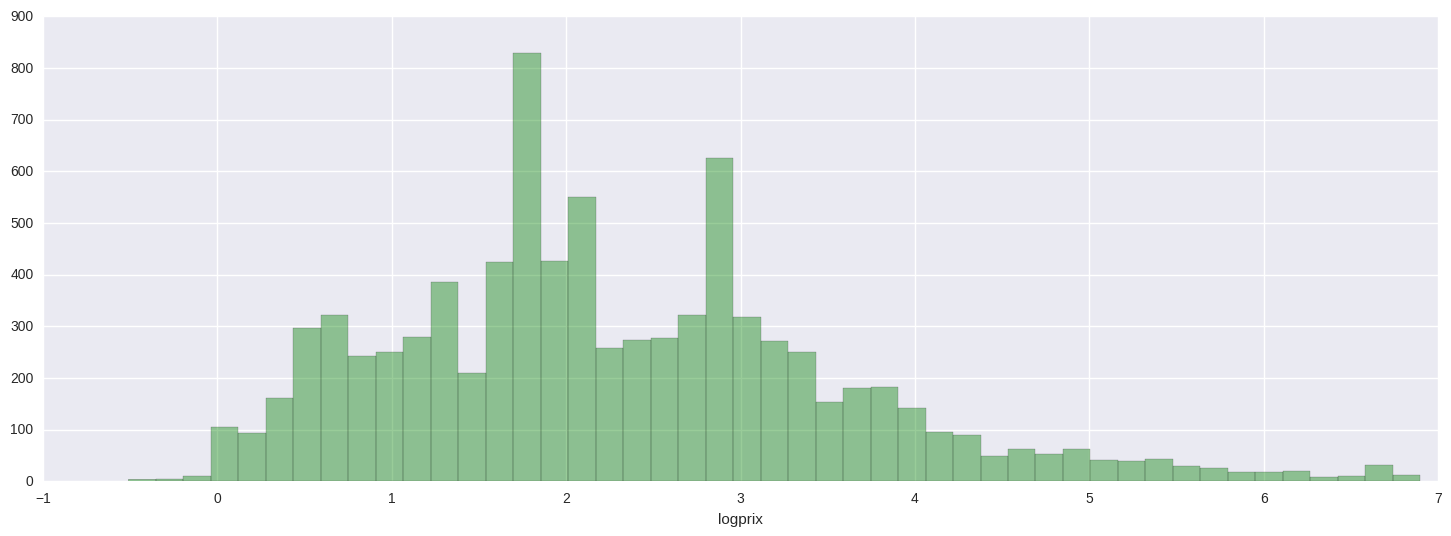

In [17]:
# On prend le log des prix car sa distribution est plus proche d'une gaussienne
plt.figure(figsize=(18, 6))
train['logprix'] = train['prix'].apply(np.log)
sns.distplot(train['logprix'], color='green', kde=False)

## Data Transformation : Taux remboursement

In [ ]:
# Influence sur les prix de la feature "tx rembours"
sns.violinplot(y="logprix", x="tx rembours", data=train)

In [ ]:
txrembours = [int(x.replace("%", "")) for x in BIG["tx rembours"]]
    
SAMPLE = pd.DataFrame({"tx rembours":BIG["tx rembours"], "tx rembours transform":txrembours})

SAMPLE[37:43]

## Data Transformation : Voies Admin
Les valeurs sont séparées par des ","

In [ ]:
BASKET_DF = pd.DataFrame(
    data = {'JOUEUR':["Tony PARKER","Michael JORDAN","Kobe BRYANT"],
            'CLUB':["INSEP, PSG, SAN ANTONIO SPURS","CHICAGO BULLS, WASHINGTON WIZARDS","LOS ANGELES LAKERS"]},
    columns=['JOUEUR', 'CLUB'])

BASKET_DF

In [ ]:

distinctCategs = (BASKET_DF['CLUB']
                  .apply(lambda col_value : col_value.split(','))
                  .apply(pd.Series)
                  .unstack()
                  .dropna()
                  .unique())

for distinctCateg in distinctCategs:
    BASKET_DF[distinctCateg] = BASKET_DF['CLUB'].apply(lambda x : 1 if distinctCateg in x else 0)
    
BASKET_DF

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 15px">Tout commence ici !!! Ready ???</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>

## Types de features

In [ ]:
# features numériques
feat_num = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule'] + ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']

# features date
feat_dates = ['date declar annee', 'date amm annee']

# features catégorielles
feat_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours',
          'voies admin', 'statut admin', 'type proc']

# features texte
feat_text = ['libelle', 'titulaires', 'substances', 'forme pharma']

## Configuration des variables à transformer, encoder, dummifier, supprimer

In [ ]:
featToDel = ['libelle', 'id']
featToDummy = []
featToDummy.extend(feat_cat)
featToDummy.extend(feat_text)
featToDummy.remove('tx rembours')
featToDummy.remove("voies admin")
featToDummy.remove("libelle")
featToEncode = []
featToTransform = ["convertTx", "log", "convertVoiesAdmin"]

config = {"featToDel":featToDel,
          "featToDummy":featToDummy,
          "featToEncode":featToEncode,
          "featToTransform":featToTransform}

print "DELETE    :  ", featToDel
print "DUMMY     :  ", featToDummy
print "ENCODE    :  ", featToEncode
print "TRANSFORM :  ", featToTransform

## La méthode Parse

In [ ]:
def parse(X, config, silent=False) :
    start = datetime.datetime.today().now()
    if not silent:
        print '__________________________________________ PARSE __________________________________________'
        print '--> ', start.strftime('%d-%m-%Y : %H:%M')
        print 'BEFORE : ', X.shape

    # Data Transformation
    if "convertVoiesAdmin" in config["featToTransform"]:
        distinctCategs = (X['voies admin']
                  .apply(lambda col_value : col_value.split(','))
                  .apply(pd.Series)
                  .unstack()
                  .dropna()
                  .unique())

        for distinctCateg in distinctCategs:
            X[distinctCateg] = X['voies admin'].apply(lambda x : 1 if distinctCateg in x else 0)
        
        X.drop("voies admin", axis =1, inplace=True)
        
    if "convertTx" in config["featToTransform"]:
        print "convert tx rembours"
        X["tx rembours"] = [int(x.replace("%", "")) for x in X["tx rembours"]]
    
    # Remove target
    y_train = X.loc[X.source == 'train',TARGET]
    
    if "log" in config["featToTransform"]:
        y_train = y_train.apply(np.log)
    
    del X[TARGET]
    
    print "---Feature to encode "
    #Feature to encode
    featToEncode = config["featToEncode"]
    for encodeToCat in featToEncode:
        print "encode " + encodeToCat
        le = LabelEncoder()
        le.fit(X[encodeToCat])
        X.loc[:,encodeToCat] = le.transform(X[encodeToCat])
    
    print "---Feature to dummy "
    #Feature to dummy
    featToDummy = config["featToDummy"]
    if featToDummy:
        dums = pd.get_dummies(X[featToDummy]).astype(int)
        X = pd.concat([X, dums], axis=1)
        X.drop(featToDummy, axis =1, inplace=True)
    
    print "---Feature to delete "
    #Feature to delete
    featToDel = config["featToDel"]
    X.drop(featToDel, axis =1, inplace=True)
     
    X_train = X[X[SOURCE] == TRAIN]
    X_test = X[X[SOURCE] == TEST]    
    del X_test[SOURCE]
    del X_train[SOURCE]
    
    
    if not silent:
        print '%s Elapsed time :%d s' % (datetime.datetime.today().now().strftime('--> %d-%m-%Y : %H:%M'), 
        (datetime.datetime.today().now().now() - start).total_seconds())
        print 'AFTER TRAIN :', X_train.shape
        print 'AFTER TEST :', X_test.shape
        sys.stdout.flush()
    
    return X_train, X_test, y_train

In [ ]:
X_train, X_test, y_train = parse(BIG.copy(), config)

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 120px">Cross Validation & Modèles</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>

## Métrique MAPE

La métrique MAPE n'étant pas disponible dans scikit-learn, nous la codons

In [ ]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Cross Validation

In [ ]:
def crossVal (X, y, clf, scorer, n_splits=5, random_state =0, shuffle = False) :
    
    folds= ms.KFold(n_splits=n_splits, shuffle= shuffle)
    
    # When shuffle=True, pseudo-random number generator state used for shuffling.
    # If None, use default numpy RNG for shuffling
    
    scoreList = []
    i = 0
    for trainIdx, testIdx in folds.split(X):
        i +=1 
        XTrainFolds = None; XTestFolds = None; yTrainFolds= None; yTestFolds= None
        yPred = []
        XTrainFolds, XTestFolds = X.iloc[trainIdx], X.iloc[testIdx]
        yTrainFolds, yTestFolds = y.iloc[trainIdx], y.iloc[testIdx]
        clf = clf.fit(XTrainFolds, yTrainFolds)
        res = clf.predict(XTestFolds)
        
        if "log" in config["featToTransform"]:
            score = scorer(np.exp(yTestFolds), np.exp(res))
        else:
            score = scorer(yTestFolds, res)
        
        scoreList.append(score)
        print "*** MAPE Error : " + str(i) + " - " + str(score)
        sys.stdout.flush()
        
    print "----------------"
    print "  - Mean :" + str(np.mean(scoreList))
    print "  - Ecart Max-Min :" + str(np.max(scoreList) - np.min(scoreList))

In [ ]:
clf = ExtraTreesRegressor(n_estimators=11, max_features= 'auto', criterion="mse", max_depth=None, min_samples_split=5, n_jobs=-1)

#clf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

#clf = GradientBoostingRegressor(verbose = 1, max_features='auto')

In [ ]:
crossVal(X_train, y_train, clf, mape_error)

<table style="border: 1;" cellpadding="0" cellspacing="0">
<tr style="border: 0;">
<td style="border: 0;"><img src="files/TDS.png"> </td>
<td style="border: 0; text-align: center; font-size: 36px; padding: 0 110px">Résultats finaux & Soumission</td>
<td style="border: 0;"><img = src="files/MDF2.png"></td>
</tr>
</table>


In [ ]:
# On entraine de nouveau le modèle, cette fois sur l'intégralité des données
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
if "log" in config["featToTransform"]:
    predictions = np.exp(predictions)

In [ ]:
pd.DataFrame(predictions, index=test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')